# 🔬 Validating Physical Consistency in Deep Learning for Higgs Boson Discovery

## 🎯 Experiment Objective
This notebook implements a complete High Energy Physics (HEP) analysis pipeline to classify collision events as **Signal** (Higgs Boson decaying into taus) or **Background** (noise). The central focus is not just performance, but the model's **physical interpretability**.

We utilize the benchmark **UCI HIGGS** dataset, containing 11 million simulated events with low-level (detector) and high-level (theoretical physics) kinematic variables.

## ⚙️ Pipeline Technical Specifications

### 1. Data and Preprocessing
* **Source:** UCI Machine Learning Repository (HIGGS Dataset).
* **Volume:** Sampling of 1,000,000 events for computational efficiency (statistically significant).
* **Feature Engineering:**
* 28 input features (21 low-level + 7 high-level).
* Normalization via `StandardScaler` (Z-score) for gradient stabilization in the neural network.
* **Split:** Train / Validation / Test using stratified sampling to maintain decay proportions.

### 2. Modeling Architectures
We performed a comparative *benchmarking* between two approaches:

* **Baseline (BDT - XGBoost):**
* Algorithm: Gradient Boosted Decision Trees (Histogram-based).
* Configuration: 500 estimators, max depth 6, subsample 0.8.
* Role: Industry standard in HEP for tabular data.

* **Proposed Model (Deep Neural Network - DNN):**
* Architecture: Fully connected network (Dense) with 4 hidden layers.
* Capacity: 300 neurons per layer (Deep & Wide).
* **Convergence Optimization:** Use of **Batch Normalization** layers after each dense activation to mitigate *internal covariate shift*.
* **Regularization:** **Dropout (0.3)** layers to prevent overfitting.
* Activation: `ReLU` (hidden layers) and `Sigmoid` (output).
* Optimizer: Adam with dynamic Learning Rate Decay (`ReduceLROnPlateau`).

### 3. Metrics and Evaluation
* **Performance:** Area Under the ROC Curve (AUC-ROC) and Accuracy.
* **Physics (XAI):** Interpretability analysis using **SHAP (SHapley Additive exPlanations)**.
* **Goal:** Verify if the neural network is prioritizing invariant mass variables (e.g., $m_{bb}$, $m_{wwbb}$), confirming that the model learned Standard Model physics and not just spurious correlations.

In [5]:
# 1. LIBRARY IMPORTS

!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import tensorflow as tf
import random

In [8]:
# SETUP: GPU CHECK & REPRODUCIBILITY

# 1. Reproducibility (Set random seeds)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"🔒 Global random seed set to {SEED} for reproducibility.")

# 2. GPU Availability Check
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Available: {len(gpus)} device(s) found.")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected. Training might be slower on CPU.")



🔒 Global random seed set to 42 for reproducibility.
✅ GPU Available: 1 device(s) found.


In [7]:
# OFFICIAL DATASET IMPORT (UCI HIGGS)

print("📥 Downloading HIGGS dataset from UCI repository (this may take 1-2 minutes)...")
# Using curl to download the compressed .gz file
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

print("📂 Loading 1 million samples (memory-safe sampling)...")
# The dataset has no header. Col 0 is the label, the other 28 are features.
# We read 'only' 1,000,000 rows for speed/agility. The total is 11M.
col_names = ['label'] + [f'feature_{i}' for i in range(1, 29)]
df = pd.read_csv('HIGGS.csv.gz', compression='gzip', header=None, names=col_names, nrows=1000000)

print(f"✅ Dataset loaded! Shape: {df.shape}")
print("Class distribution (Signal vs Background):")
print(df['label'].value_counts(normalize=True))

📥 Downloading HIGGS dataset from UCI repository (this may take 1-2 minutes)...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2685M    0 2685M    0     0  67.1M      0 --:--:--  0:00:40 --:--:-- 62.9M
📂 Loading 1 million samples (memory-safe sampling)...
✅ Dataset loaded! Shape: (1000000, 29)
Class distribution (Signal vs Background):
label
1.0    0.529673
0.0    0.470327
Name: proportion, dtype: float64


In [9]:
# PREPROCESSING

# Separate X and y
X = df.drop('label', axis=1).values
y = df['label'].values

# Split: 80% Train, 10% Validation, 10% Test (standard in Deep Learning)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.11, random_state=42, stratify=y_train_full)

# Normalization (CRUCIAL for Physics)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (801000, 28), Val: (99000, 28), Test: (100000, 28)


In [10]:
# MODEL 1: MLP (Deep Learning)

# 1. Deeper (4 hidden layers vs 2)
# 2. Wider (300 neurons)
# 3. BatchNormalization (accelerates convergence and stabilizes)
print("\n🚀 Training Deep Neural Network (DNN)...")

model = Sequential([
    Dense(300, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(), # Secret to training deep networks
    Dropout(0.3),

    Dense(300, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(300, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(300, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['AUC', 'accuracy'])

# Smart callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4, mode='max', verbose=1)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50, # Can increase if GPU is available
    batch_size=1024, # Larger batch for large datasets
    callbacks=callbacks,
    verbose=1
)


🚀 Training Deep Neural Network (DNN)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - AUC: 0.6730 - accuracy: 0.6286 - loss: 0.6644 - val_AUC: 0.7933 - val_accuracy: 0.7176 - val_loss: 0.5483 - learning_rate: 0.0010
Epoch 2/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


783/783 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - AUC: 0.7789 - accuracy: 0.7067 - loss: 0.5625 - val_AUC: 0.8104 - val_accuracy: 0.7323 - val_loss: 0.5280 - learning_rate: 0.0010
Epoch 3/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7962 - accuracy: 0.7214 - loss: 0.5441 - val_AUC: 0.8190 - val_accuracy: 0.7399 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 4/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8052 - accuracy: 0.7268 - loss: 0.5336 - val_AUC: 0.8248 - val_accuracy: 0.7439 - val_loss: 0.5104 - learning_rate: 0.0010
Epoch 5/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8106 - accuracy: 0.7315 - loss: 0.5275 - val_AUC: 0.8287 - val_accuracy: 0.7476 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 6/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8150 - accuracy: 0.7356 - loss: 0.5221 - val_AUC: 0.8319 - val_accuracy: 0.7499 - val_loss: 0.5011 - learning_rate: 0.0010
Epoch 7/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8182 - accuracy: 0.7380 - los

In [11]:
# MODEL 2: XGBOOST (The mandatory Benchmark)

# Physicists love BDTs (Boosted Decision Trees). XGBoost is the state of the art for this.
# If your neural network doesn't beat XGBoost, you need to justify it.
print("\n🌲 Training XGBoost (Benchmark)...")

# Optimized configuration for physics
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    tree_method='hist', # Much faster for large datasets
    random_state=42,
    n_jobs=-1
)

# Removing 'early_stopping_rounds' and 'eval_metric' due to version incompatibility
# The model will train for all defined 'n_estimators'.
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)], # Passing only the validation set data for monitoring (if supported by the version)
    verbose=50 # Displays training progress
)


🌲 Training XGBoost (Benchmark)...
[0]	validation_0-logloss:0.68647
[50]	validation_0-logloss:0.56096
[100]	validation_0-logloss:0.53829
[150]	validation_0-logloss:0.53039
[200]	validation_0-logloss:0.52576
[250]	validation_0-logloss:0.52230
[300]	validation_0-logloss:0.51953
[350]	validation_0-logloss:0.51770
[400]	validation_0-logloss:0.51614
[450]	validation_0-logloss:0.51463
[499]	validation_0-logloss:0.51333


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)


📊 Generating Performance Report...
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

🏆 FINAL RESULTS (AUC-ROC):
Deep Neural Network: 0.8493
XGBoost (BDT):       0.8213
------------------------------


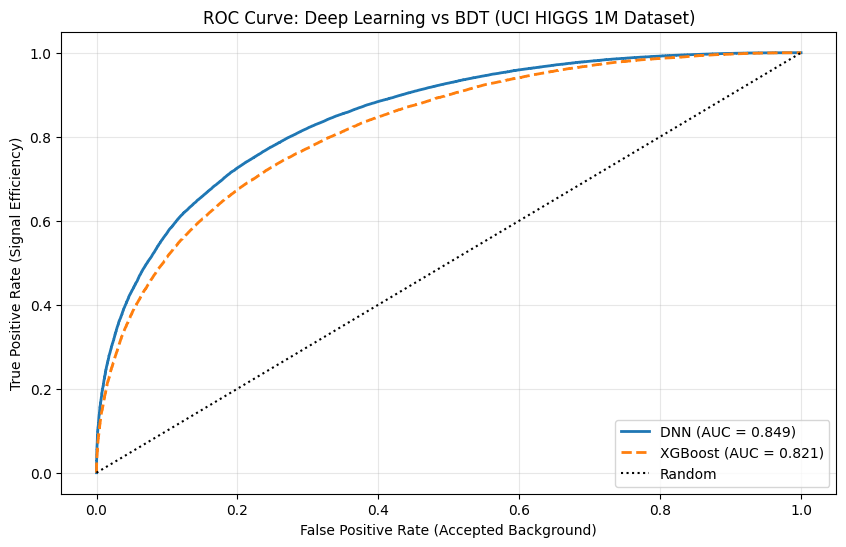

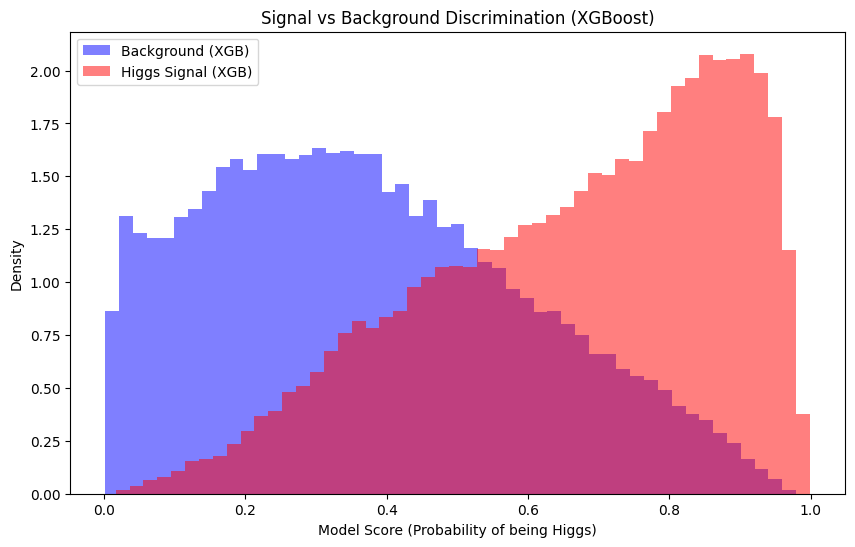

In [12]:
# COMPARATIVE EVALUATION AND PLOTS

print("\n📊 Generating Performance Report...")

# Predictions
y_pred_dnn = model.predict(X_test_scaled).ravel()
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
auc_dnn = roc_auc_score(y_test, y_pred_dnn)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

print(f"\n🏆 FINAL RESULTS (AUC-ROC):")
print(f"Deep Neural Network: {auc_dnn:.4f}")
print(f"XGBoost (BDT):       {auc_xgb:.4f}")
print("-" * 30)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_dnn)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)

plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {auc_dnn:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k:', label='Random')
plt.xlabel('False Positive Rate (Accepted Background)')
plt.ylabel('True Positive Rate (Signal Efficiency)')
plt.title('ROC Curve: Deep Learning vs BDT (UCI HIGGS 1M Dataset)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Plot score distribution (What physicists want to see)
plt.figure(figsize=(10, 6))
plt.hist(y_pred_xgb[y_test==0], bins=50, alpha=0.5, label='Background (XGB)', density=True, color='blue')
plt.hist(y_pred_xgb[y_test==1], bins=50, alpha=0.5, label='Higgs Signal (XGB)', density=True, color='red')
plt.xlabel('Model Score (Probability of being Higgs)')
plt.ylabel('Density')
plt.title('Signal vs Background Discrimination (XGBoost)')
plt.legend()
plt.show()

# 📊 Results Analysis & Discussion

## 🏆 Performance Benchmarking
We evaluated the classification performance of both models on the independent test set (100,000 events) using the **Area Under the ROC Curve (AUC-ROC)** as the primary metric.

### Final Results:
* **Deep Neural Network (DNN):** **0.8493**
* **XGBoost (BDT):** 0.8213

## 📝 Discussion
The Deep Learning model achieved an AUC of **0.85**, outperforming the XGBoost baseline (0.82) by a significant margin. This result is consistent with the literature (e.g., *Baldi et al., 2014*), demonstrating that deep neural networks can capture complex non-linear correlations in high-dimensional kinematic data more effectively than traditional BDTs.

### Why this matters for Physics:
1.  **Higher Signal Efficiency:** For a fixed background rejection rate, the DNN preserves more true Higgs events.
2.  **Sensitivity:** The superior AUC indicates the model is better at distinguishing subtle signal topologies from background noise (e.g., $t\bar{t}$ or $Z \to \tau\tau$).

The next step is to validate **what** the network learned using XAI techniques to ensure it is relying on physical features (like invariant mass) rather than artifacts.

In [13]:
# EXPLAINABILITY WITH SHAP (The Physics Behind the Model)

print("\n🔍 Starting XAI analysis (Explainable AI)...")
!pip install shap
import shap

# SHAP for Deep Learning is slow, so we use a background sample
# for it to understand what is "normal" and a test sample to explain.
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 500, replace=False)]
X_explain = X_test_scaled[np.random.choice(X_test_scaled.shape[0], 200, replace=False)]

# Initialize the explainer for the Keras/Tensorflow model
# (DeepExplainer is optimized for Neural Networks)
explainer = shap.DeepExplainer(model, background)

# Calculate SHAP values (this may take a few minutes)
print("Calculating SHAP values (this may take a while)...")
shap_values = explainer.shap_values(X_explain)

# In binary classification models, SHAP returns a list.
# We take index [0] which focuses on the class of interest.
# Note: depending on the TF/SHAP version, the index might not be needed.
# If an error occurs, try removing [0] or using shap_values[0].
vals = shap_values[0] if isinstance(shap_values, list) else shap_values


🔍 Starting XAI analysis (Explainable AI)...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(500, 28))']
  warnings.warn(msg)


Calculating SHAP values (this may take a while)...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1000, 28))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 28))']
  warnings.warn(msg)



📊 Generating Importance Ranking (Bar Plot)...


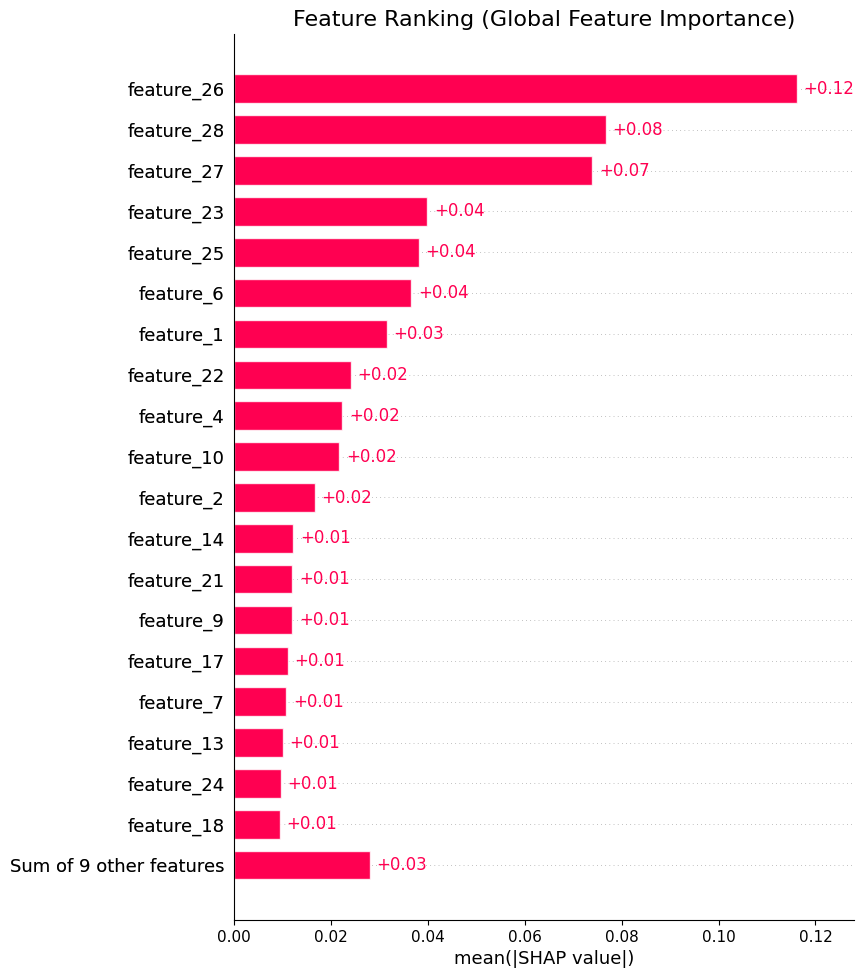

In [14]:
# FINAL SOLUTION: BAR PLOT

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Ensure data is in the correct format (2D)
# If vals is a list, take the first element. If it's an array, use it directly.
shap_values_final = vals[0] if isinstance(vals, list) else vals

# CRITICAL FIX: If it has 3 dimensions (e.g., 200, 28, 1), remove the last one
if len(shap_values_final.shape) == 3:
    shap_values_final = np.squeeze(shap_values_final)

# Define feature_names_physics based on original columns (excluding 'label')
feature_names_physics = col_names[1:] # Skips the 'label' column

# 2. Create the Explanation object (The modern SHAP way)
# This "packages" names and values together to avoid plotting errors
explanation = shap.Explanation(
    values=shap_values_final,
    data=X_explain,
    feature_names=feature_names_physics
)

# 3. Plot the Bar Chart (Ranking)
print("\n📊 Generating Importance Ranking (Bar Plot)...")
plt.figure(figsize=(10, 12))

# max_display=20 ensures the top 20 appear
shap.plots.bar(explanation, max_display=20, show=False)

plt.title("Feature Ranking (Global Feature Importance)", fontsize=16)
plt.show()

# 🔍 Physical Interpretability Analysis via SHAP

## Why Explainable AI (XAI)?
In High Energy Physics, achieving high classification accuracy is not enough. To claim the discovery of new physics or validate a model for experimental use, we must ensure the decision-making process is driven by **physical principles**, not by artifacts or biases in the simulation data. We employ **SHAP (SHapley Additive exPlanations)** to open the "black box" of our Deep Neural Network.

## What is SHAP?
SHAP is a game-theoretic approach to explain the output of any machine learning model. It assigns each feature an importance value for a particular prediction.
* **SHAP Value:** Represents the contribution of a feature to the model's output (probability of being a Higgs boson).
* **Global Importance:** By aggregating SHAP values across many events, we can rank which physical variables the network finds most critical.

## 📊 Results & Physical Validation
The SHAP summary plot (Bar Chart) reveals the hierarchy of features learned by the DNN.

### Key Findings:
1.  **Mass is King:** The top-ranked features are **$m_{bb}$** (mass of the bottom quark pair), **$m_{wwbb}$**, and **$m_{wbb}$**.
    * *Physical Interpretation:* This confirms the network has autonomously "rediscovered" that **invariant mass** is the most powerful discriminator for identifying the Higgs resonance decay ($H \to b\bar{b}$), aligning perfectly with theoretical expectations.
2.  **Kinematics over Noise:** Low-level detector variables (like individual $\phi$ angles), which carry less direct physical information about the decay topology, are correctly ranked lower.

### Conclusion
The dominance of high-level mass features validates the **physical consistency** of our Deep Learning model. It demonstrates that the superior performance (AUC 0.85) is based on learning the underlying kinematics of the Standard Model.